In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
import numpy as np
import re

In [2]:
zomato_data_path = 'gs://foundation_project2/training_folder/zomato.csv'
df = pd.read_csv(zomato_data_path)

In [3]:
df.sample(n=10)

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,menu_item,listed_in_type,listed_in_city
8415,https://www.zomato.com/bangalore/blue-berry-re...,"41, 7th Main Road, New Extension, Abbaappa Lay...",Blue Berry Restaurant,No,No,2.9,17,+91 9008255007,BTM,Casual Dining,NaN,"North Indian, Kerala, Chinese",600.0,NaN,Dine-out,BTM
14316,https://www.zomato.com/bangalore/meaza-ginger-...,"51, Near ESI Hospital, Double Road, Indiranaga...",Meaza Ginger Multi Cuisine Restaurant,Yes,No,3.6,91,080 25215707\r\n+91 7676922228,Indiranagar,Casual Dining,"Biryani, Chicken Curry, Kerala Parotta, Appam,...","North Indian, Chinese, South Indian, Kerala",550.0,NaN,Delivery,Indiranagar
23614,https://www.zomato.com/bangalore/wtf-koramanga...,"63, 5th Block, Jyoti Nivas College Road, Koram...",WTF,Yes,No,4.1,93,080 43758178,Koramangala 5th Block,Cafe,"Cheesy Pizza, Cheese Pasta, Brownie Milkshake,...","Cafe, Continental",600.0,"Margherita Pizza, BBQ Chicken Pizza, Chicken P...",Delivery,Koramangala 5th Block
8507,https://www.zomato.com/bangalore/body-temple-b...,"2nd cross, Behind Anjaneya Temple, Opposite Pr...",Body Temple,Yes,No,3.3,12,+91 9033435979,BTM,Quick Bites,NaN,Healthy Food,500.0,"Natural Skim Milkshake, Plain Boiled Chicken B...",Dine-out,BTM
32768,https://www.zomato.com/bangalore/melting-melod...,"90/3, Munnekolala Outer Ring Road, Marathahall...",Melting Melodies,No,No,3.4,34,NaN,Marathahalli,Dessert Parlor,NaN,"Bakery, Desserts",NaN,NaN,Delivery,Marathahalli
4605,https://www.zomato.com/bangalore/kaara-by-the-...,"119, Annaswamy Mudaliar Road, Opposite Ulsoor ...",KAARA BY THE LAKE,No,No,4.0,47,+91 8025565676,Ulsoor,Cafe,"Coffee, Pizza, Pasta, Key Lime Pie","Cafe, Italian, Coffee",750.0,NaN,Delivery,Brigade Road
20373,https://www.zomato.com/bangalore/zamindars-bir...,"48, 1st Floor,beside new Udupi Upahar,Next To ...",Zamindars Biryani Durbar,Yes,Yes,4.3,53,+91 8722033342,Nagawara,Casual Dining,Hyderabadi Chicken Dum Biryani,"Biryani, Chinese, Mughlai, Andhra",600.0,"Paneer 65, Chicken 65, Kodi Vepudi, Chicken Sh...",Delivery,Kammanahalli
28496,https://www.zomato.com/bangalore/fava-bistro-k...,"8, Jailaxmi Nivas, Koramangala 5th Block, Bang...",Fava Bistro,Yes,Yes,4.4,387,080 43029777\n+91 7899758222,Koramangala 5th Block,"Casual Dining, Bar","Pizza, Pita Bread, Beer Cocktail, Baklava, Shr...","Mediterranean, Pizza, Italian, Beverages",1500.0,"Classic Organic Chickpea Hummus, Moroccan Brio...",Delivery,Koramangala 7th Block
16869,https://www.zomato.com/bangalore/navami-jayana...,"488/108, East End Main Road, 9th Block, Jayana...",Navami,Yes,No,3.5,80,080 22443498\r\n080 22443499,Jayanagar,Casual Dining,"Biryani, Fried Rice Chicken","Andhra, North Indian, Chinese, Mangalorean, Se...",750.0,"Aloo Bonda, Chicken Thali, Fish Thali, Chicken...",Dine-out,Jayanagar
35928,https://www.zomato.com/bangalore/hyderabadi-ba...,"16, Tata Nagar Main Road, Next To BP Petrol Bu...",Hyderabadi Bawarchi Multi Cuisine Restaurant,No,No,3.0,100,080 65666599\n+91 9902306464,Hebbal,Casual Dining,NaN,"Biryani, North Indian, Chinese",600.0,NaN,Dine-out,New BEL Road


# Check distinct values of output variable

In [4]:
df.rate.value_counts().to_dict()

{3.9: 3972,
 3.8: 3873,
 3.7: 3821,
 3.6: 3316,
 4.0: 3183,
 4.1: 2948,
 3.5: 2784,
 3.4: 2476,
 3.3: 2310,
 4.2: 2184,
 3.2: 1873,
 4.3: 1693,
 3.1: 1561,
 4.4: 1147,
 3.0: 1023,
 2.9: 802,
 4.5: 656,
 2.8: 600,
 2.7: 307,
 4.6: 300,
 2.6: 260,
 4.7: 167,
 2.5: 101,
 2.4: 70,
 4.8: 66,
 4.9: 55,
 2.3: 51,
 2.2: 26,
 2.1: 24,
 2.0: 11,
 1.8: 5}

**Observation:** There are many ratings with uncleaned texts we have to manage them

# Feature selection by problem statement
As per our problem statement we will make the feature selection as below for modelling purpose:

| Feature | Comments |
| :- | :- |
| url | Not used URL has nothing to do with ratings |
| address | Raw address is not required as we will focus on location information |
| name | Name has nothing to do with rating |
| online_order | **Required**. We need to model with online_order. Online delivery service plays good role |
| book_table | **Required**. Table booking feature can play good role in ratings |
| rate | **Required**.  Target variable |
| votes | Not selected as new restaurants which will be onboarded will have little or no votes. Cold start problem |
| phone | Not required|
| location | May be required. We are also capturing the info in **listed_in(city)** |
| rest_type | **Required**. Restaurant type might have some effect |
| dish_liked | Not required. New onboarded restaurant will not have this info. |
| cuisines | **Required**. |
| approx_cost(for two people) | **Required**. |
| reviews_list | Not required as of now. Cold start problem. |
| menu_item | **Required**. Requires data cleaning |
| listed_in(type) | **Required**. |
| listed_in(city) | **Required**.  |

# Column Renames

In [5]:
rename_dict = {'approx_cost(for two people)':'cost'
               ,'listed_in(type)':'listed_in_type'
               ,'listed_in(city)':'listed_in_city'
              }
df = df.rename(columns=rename_dict)
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,cost,menu_item,listed_in_type,listed_in_city
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800.0,NaN,Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800.0,NaN,Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800.0,NaN,Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300.0,NaN,Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600.0,NaN,Buffet,Banashankari


# Feature elimination based on problem statement
Below we will select only the features that we think might be useful as per our problem statement

In [6]:
columns_selected = ['online_order',
                    'book_table',
                    'location',
                    'rest_type',
                    'cuisines',
                    'cost',
                    'menu_item',
                    'listed_in_type',
                    'listed_in_city',
                    'rate'
                   ]
df = df[columns_selected]

In [7]:
df.sample(n=10)

,online_order,book_table,location,rest_type,cuisines,cost,menu_item,listed_in_type,listed_in_city,rate
7778,No,No,BTM,Quick Bites,"Italian, Pizza",650.0,NaN,Delivery,BTM,3.6
10862,Yes,No,Electronic City,Quick Bites,"Chinese, Fast Food, Italian",400.0,NaN,Delivery,Electronic City,3.7
1371,Yes,No,Bannerghatta Road,Casual Dining,"North Indian, Biryani, Chinese, Seafood",550.0,NaN,Delivery,Bannerghatta Road,3.0
11438,Yes,No,Electronic City,Quick Bites,South Indian,300.0,NaN,Dine-out,Electronic City,3.7
20382,No,No,Kammanahalli,"Casual Dining, Bar","North Indian, Chinese, Continental",500.0,NaN,Delivery,Kammanahalli,3.8
24420,Yes,No,Koramangala 5th Block,"Beverage Shop, Quick Bites","Beverages, Fast Food, Desserts",350.0,NaN,Delivery,Koramangala 5th Block,4.0
37665,No,Yes,Rajajinagar,Casual Dining,"Pizza, Biryani, North Indian, South Indian",800.0,NaN,Dine-out,Rajajinagar,4.3
40671,Yes,No,Brookefield,Beverage Shop,"Beverages, Fast Food",600.0,"Veg Momos, Vanilla Sky, Cold Coffee, Nutella, ...",Delivery,Whitefield,4.0
39568,Yes,No,Bellandur,Beverage Shop,"Beverages, Fast Food",600.0,NaN,Delivery,Sarjapur Road,4.1
12984,Yes,No,HSR,Delivery,"Street Food, Fast Food, Rolls, Desserts",200.0,NaN,Delivery,HSR,4.0


**Observation:**
1. cuisines, menu_item, rest_type require count vectorization using ', ' separated values
1. online_order, book_table, listed_in_city, listed_in_type require one hot encoding

# Simple EDA

## Categorical columns

In [8]:
categorical_cols = ['online_order',
                    'book_table',
                    'location',
                    'rest_type',
                    'listed_in_type',
                    'listed_in_city'
                   ]
for col in categorical_cols:
    print('****{}****'.format(col))
    print(df[col].value_counts().to_dict())
    print('-'*5,'NaNs present','-'*5)
    print(df[col].isna().sum())

****online_order****
{'Yes': 27206, 'No': 14459}
----- NaNs present -----
0
****book_table****
{'No': 35361, 'Yes': 6304}
----- NaNs present -----
0
****location****
{'BTM': 3930, 'Koramangala 5th Block': 2319, 'HSR': 2019, 'Indiranagar': 1847, 'JP Nagar': 1717, 'Jayanagar': 1643, 'Whitefield': 1582, 'Marathahalli': 1443, 'Bannerghatta Road': 1235, 'Koramangala 6th Block': 1077, 'Koramangala 7th Block': 1060, 'Brigade Road': 1052, 'Bellandur': 1012, 'Sarjapur Road': 866, 'Koramangala 1st Block': 852, 'Ulsoor': 849, 'Koramangala 4th Block': 841, 'Electronic City': 840, 'MG Road': 811, 'Banashankari': 744, 'Kalyan Nagar': 698, 'Malleshwaram': 642, 'Richmond Road': 612, 'Residency Road': 605, 'Basavanagudi': 595, 'Frazer Town': 570, 'Church Street': 546, 'Brookefield': 545, 'New BEL Road': 508, 'Kammanahalli': 501, 'Lavelle Road': 487, 'Banaswadi': 480, 'Cunningham Road': 475, 'Rajajinagar': 461, 'Domlur': 409, 'Shanti Nagar': 368, 'Old Airport Road': 358, 'St. Marks Road': 343, 'Shivajin

**Observation:** 
1. We can substitute some locations which have very less counts as "Others"
1. rest_type is not a one-to-one mapping. It needs to be handled through count Vectorizer.
1. There can be direct correlation of **listed_in(city)** and **location**. As per our understanding **listed_in(city)** seems to be more drill down of **location**. So for overall view, we can go with **listed_in(city)**. Need to confirm with B'lore people on these. However there are presence of NaNs in the **location** field. So we will use **listed_in(city)** for it has complete information.
1. Fields like **rest_type** contains too many categories which are comma-separated. We need to perform encoding by count vectorization

In [9]:
df.sample(n=10)

,online_order,book_table,location,rest_type,cuisines,cost,menu_item,listed_in_type,listed_in_city,rate
575,Yes,No,Banashankari,Quick Bites,"South Indian, Street Food",150.0,NaN,Dine-out,Banashankari,3.6
36607,No,No,CV Raman Nagar,Quick Bites,"North Indian, Chinese, Rolls",500.0,NaN,Delivery,Old Airport Road,3.0
30798,Yes,No,Lavelle Road,"Bakery, Dessert Parlor","Bakery, French, Desserts",300.0,"Opera Pastry, Mango Cheese Cake Pastry, Orange...",Desserts,Lavelle Road,4.2
40456,Yes,No,Whitefield,"Dessert Parlor, Cafe","Ice Cream, Cafe, Pizza, Burger, Desserts, Beve...",500.0,NaN,Cafes,Whitefield,4.3
11939,Yes,No,Vasanth Nagar,Quick Bites,"South Indian, Street Food, Chinese, Fast Food",400.0,"Uddina Vada, Open Butter Masala Dosa, Masala D...",Delivery,Frazer Town,2.8
18936,No,No,Jayanagar,Quick Bites,"Chinese, Italian, Fast Food, Momos",400.0,NaN,Dine-out,JP Nagar,3.6
1198,Yes,No,Bannerghatta Road,"Takeaway, Delivery","Chinese, Fast Food, North Indian",500.0,NaN,Delivery,Bannerghatta Road,3.3
11200,No,Yes,Electronic City,"Pub, Casual Dining","Continental, North Indian, Chinese, Salad",1200.0,NaN,Dine-out,Electronic City,4.3
14059,Yes,Yes,Old Airport Road,Casual Dining,"BBQ, Arabian, Chinese, North Indian, Desserts",1000.0,NaN,Delivery,Indiranagar,4.2
20707,No,No,Kammanahalli,Bar,"North Indian, Finger Food, Chinese",700.0,NaN,Dine-out,Kammanahalli,3.0


**Observation:** So our custom column cleaner is working fine we can drop these original columns

# Segregate the unrated restaurants

In [12]:
unrated_rest = df[df.rate.isna()]
df = df[~df.rate.isna()]

In [13]:
display('Unrated restaurants:::',unrated_rest.sample(10))
display('Rated restaurants:::',df.sample(10))

ValueError: a must be greater than 0 unless no samples are taken

## Numeric columns <a id='n1'>

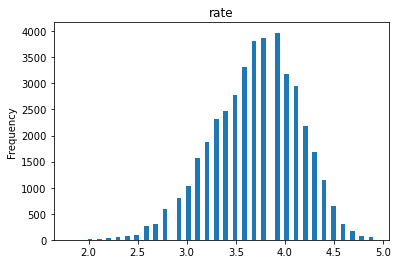

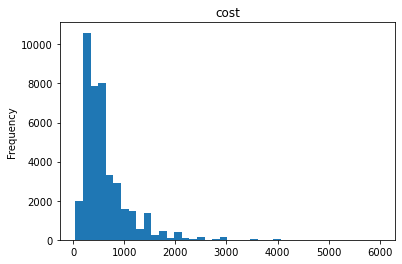

In [15]:
numeric_cols = ['rate',
                'cost'
                ]

col='rate'
df[col].plot.hist(bins=65,title=col)
plt.show()

col='cost'
df[col].plot.hist(bins=40,title=col)
plt.show()

**Observation:**
1. Ratings denote an approximate normal distribution but left skewed.
1. cost being discrete in nature (in 100s). There seems to be a slight bi-modal distribution in cost

# Correlation
Does cost has any correlation with the rating?

In [16]:
df[numeric_cols].corr()

,rate,cost
rate,1.000000,0.385183
cost,0.385183,1.000000


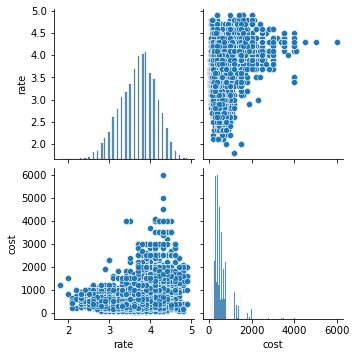

In [17]:
sns.pairplot(data=df[numeric_cols])
plt.show()

**Observation:** Cost has some correlation with ratings. Hence can be put in the model

# Feature selection by statistics
Below we will use statistical measures like:
- One factor ANOVA: To understand whether there is significant level of difference between the output variable and each level of categorical variable

## One Factor ANOVA
Here response variable is rating. We would perform one factor ANOVA a single shot test to understand whether there is significant level of rating across different levels of the given categorical column

- Null hypothesis: Mean rating is same across different levels of the given categorical variable
- Alternate hypothesis: Mean rating is not same across different levels of given categorical variable

**Expectation:** If we are able to reject null hypothesis, that qualifies the particular categorical variable for further modelling.

In [18]:
df.sample(5)

,online_order,book_table,location,rest_type,cuisines,cost,menu_item,listed_in_type,listed_in_city,rate
12500,Yes,No,Cunningham Road,"Bakery, Quick Bites","Bakery, Desserts",400.0,NaN,Dine-out,Frazer Town,3.4
36266,Yes,No,Kaggadasapura,Quick Bites,"Fast Food, Rolls",350.0,"Grill Hut Combo 1, Chicken Tikka Kabab, Chicke...",Delivery,Old Airport Road,3.6
1222,Yes,No,JP Nagar,Quick Bites,"South Indian, North Indian, Fast Food",300.0,NaN,Delivery,Bannerghatta Road,3.9
21603,Yes,Yes,Koramangala 5th Block,Pub,"Finger Food, Asian, European, Italian",1200.0,"French Fries, Chilli Chicken, Beef Steak with ...",Delivery,Koramangala 4th Block,4.1
3706,No,No,Bellandur,Cafe,Cafe,400.0,NaN,Dine-out,Bellandur,3.9


In [19]:
cols_to_check = ['online_order',
                 'book_table',
                 'rest_type',
                 'listed_in_type',
                 'listed_in_city',
               ]

rate ~ C(online_order)


,sum_sq,df,F,PR(>F)
C(online_order),37.913261,1.0,196.293114,1.697891e-44
Residual,8047.048346,41663.0,NaN,NaN


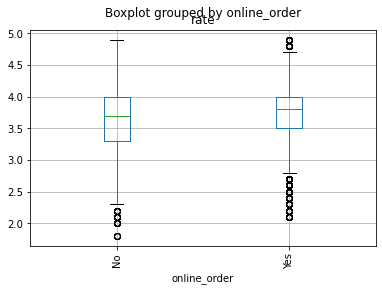

rate ~ C(book_table)


,sum_sq,df,F,PR(>F)
C(book_table),1457.810881,1.0,9164.839798,0.0
Residual,6627.150726,41663.0,NaN,NaN


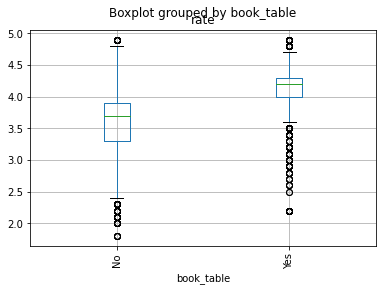

rate ~ C(rest_type)


,sum_sq,df,F,PR(>F)
C(rest_type),1495.273002,86.0,110.235756,0.0
Residual,6534.374263,41429.0,NaN,NaN


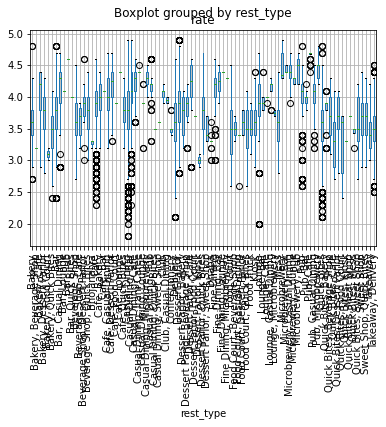

rate ~ C(listed_in_type)


,sum_sq,df,F,PR(>F)
C(listed_in_type),352.878578,6.0,316.866225,0.0
Residual,7732.083030,41658.0,NaN,NaN


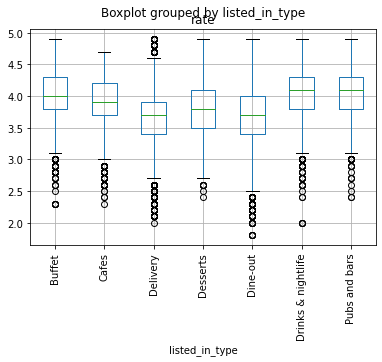

rate ~ C(listed_in_city)


,sum_sq,df,F,PR(>F)
C(listed_in_city),258.837125,29.0,47.483245,3.905529e-267
Residual,7826.124482,41635.0,NaN,NaN


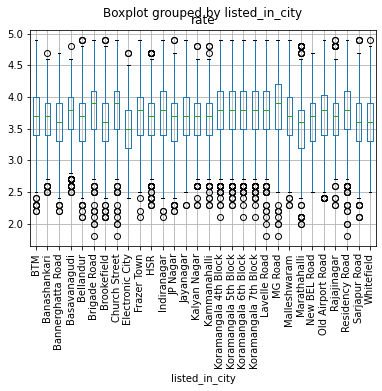

In [22]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for col in cols_to_check:
    formula = f"rate ~ C({col})"
    model = ols(formula, data= df).fit()
    print(formula)
    display(sm.stats.anova_lm(model, typ=2))
    df.boxplot(column='rate', by=col,rot=90)
    plt.show()

**Observation:** From the above statistical analysis we can say that all the chosen variables qualify for modelling.

# Final check of NaN values

In [23]:
df.isna().sum()

online_order          0
book_table            0
location              0
rest_type           149
cuisines             11
cost                247
menu_item         30700
listed_in_type        0
listed_in_city        0
rate                  0
dtype: int64

**Observation:** Thus we have removed all the NaN from the target columns.
1. For **cost** we can perform imputation using KNN Imputer
1. For rest_type,cuisines we will treat NaNs as 'unk' denoting unknown

# Re-arrange the columns
Rearrange the columns such in the following manner as per pre-processig needs:
1. One Hot Encoding columns
1. Count Vectorized Columns
1. Numeric columns

In [25]:
ohe_cols = ['online_order', 
           'book_table', 
           'listed_in_city', 
           'listed_in_type'
          ]
cv_cols = ['cuisines', 
#            'menu_item_cleaned', 
           'rest_type'
          ]
numeric_cols = ['cost']
y = ['rate']
df_rearranged = df[ohe_cols+cv_cols+numeric_cols+y]
df_rearranged.head()

,online_order,book_table,listed_in_city,listed_in_type,cuisines,rest_type,cost,rate
0,Yes,Yes,Banashankari,Buffet,"North Indian, Mughlai, Chinese",Casual Dining,800.0,4.1
1,Yes,No,Banashankari,Buffet,"Chinese, North Indian, Thai",Casual Dining,800.0,4.1
2,Yes,No,Banashankari,Buffet,"Cafe, Mexican, Italian","Cafe, Casual Dining",800.0,3.8
3,No,No,Banashankari,Buffet,"South Indian, North Indian",Quick Bites,300.0,3.7
4,No,No,Banashankari,Buffet,"North Indian, Rajasthani",Casual Dining,600.0,3.8


# Split into Train and Test sets

In [26]:
train_df, test_df = train_test_split(df_rearranged, test_size=0.3)

In [27]:
train_df.shape, test_df.shape

((29165, 8), (12500, 8))

# Pre-processing

In [28]:
X_train = np.empty(shape=(len(train_df),0))
X_test = np.empty(shape=(len(test_df),0))
dict_of_transformers = {}

In [29]:
X_train

array([], shape=(29165, 0), dtype=float64)

## Preprocess for OneHotEncoders

In [30]:
pd.set_option("display.max_columns", 999)

In [31]:
transformer_type = 'one_hot_encoder'
dict_of_transformers[transformer_type] = OneHotEncoder(drop='first', sparse=False)
X = dict_of_transformers[transformer_type].fit_transform(train_df[ohe_cols])
print('Categories found:: ', dict_of_transformers[transformer_type].get_feature_names())
display('Original column', train_df[ohe_cols].head(10))
display('Transformed df:::',pd.DataFrame(data=X, columns=dict_of_transformers[transformer_type].get_feature_names()).head(10))

Categories found::  ['x0_Yes' 'x1_Yes' 'x2_Banashankari' 'x2_Bannerghatta Road'
 'x2_Basavanagudi' 'x2_Bellandur' 'x2_Brigade Road' 'x2_Brookefield'
 'x2_Church Street' 'x2_Electronic City' 'x2_Frazer Town' 'x2_HSR'
 'x2_Indiranagar' 'x2_JP Nagar' 'x2_Jayanagar' 'x2_Kalyan Nagar'
 'x2_Kammanahalli' 'x2_Koramangala 4th Block' 'x2_Koramangala 5th Block'
 'x2_Koramangala 6th Block' 'x2_Koramangala 7th Block' 'x2_Lavelle Road'
 'x2_MG Road' 'x2_Malleshwaram' 'x2_Marathahalli' 'x2_New BEL Road'
 'x2_Old Airport Road' 'x2_Rajajinagar' 'x2_Residency Road'
 'x2_Sarjapur Road' 'x2_Whitefield' 'x3_Cafes' 'x3_Delivery' 'x3_Desserts'
 'x3_Dine-out' 'x3_Drinks & nightlife' 'x3_Pubs and bars']


'Original column'

,online_order,book_table,listed_in_city,listed_in_type
12242,No,No,Frazer Town,Dine-out
3422,Yes,No,Bellandur,Delivery
29953,No,No,Koramangala 7th Block,Dine-out
9165,No,Yes,BTM,Drinks & nightlife
13003,Yes,No,HSR,Delivery
20071,Yes,No,Kammanahalli,Delivery
7384,Yes,No,BTM,Delivery
6838,Yes,Yes,BTM,Delivery
27250,No,Yes,Koramangala 6th Block,Dine-out
14080,Yes,No,Indiranagar,Delivery


'Transformed df:::'

,x0_Yes,x1_Yes,x2_Banashankari,x2_Bannerghatta Road,x2_Basavanagudi,x2_Bellandur,x2_Brigade Road,x2_Brookefield,x2_Church Street,x2_Electronic City,x2_Frazer Town,x2_HSR,x2_Indiranagar,x2_JP Nagar,x2_Jayanagar,x2_Kalyan Nagar,x2_Kammanahalli,x2_Koramangala 4th Block,x2_Koramangala 5th Block,x2_Koramangala 6th Block,x2_Koramangala 7th Block,x2_Lavelle Road,x2_MG Road,x2_Malleshwaram,x2_Marathahalli,x2_New BEL Road,x2_Old Airport Road,x2_Rajajinagar,x2_Residency Road,x2_Sarjapur Road,x2_Whitefield,x3_Cafes,x3_Delivery,x3_Desserts,x3_Dine-out,x3_Drinks & nightlife,x3_Pubs and bars
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [32]:
X_train = np.hstack((X_train,X))
X_test = np.hstack((X_test,dict_of_transformers[transformer_type].transform(test_df[ohe_cols])))
X_train.shape, X_test.shape

((29165, 37), (12500, 37))

## Preprocess Count Vectorizers
The columns which needed to be preprocessed using count vectorizers contains the values in comma separated manner which means restaurants can be of different categories

In [33]:
for col in cv_cols:
    print('\n******', col,'*****')
    # fill na
    train_df[col] = train_df[col].fillna('unk')
    test_df[col] = test_df[col].fillna('unk')
    regex = '\, '
    dict_of_transformers[col] = CountVectorizer(tokenizer=lambda text: re.split(regex,text), binary=True, min_df=10)
    X = dict_of_transformers[col].fit_transform(train_df[col])
    X = X.toarray()
    print('# of Categories found:: ', len(dict_of_transformers[col].get_feature_names()))
    display('Original column', train_df[col].head(10))
    display('Transformed df:::',pd.DataFrame(data=X, columns=dict_of_transformers[col].get_feature_names()).head(10))
    
    X_train = np.hstack((X_train,X))
    X_test_temp = dict_of_transformers[col].transform(test_df[col]).toarray()
    X_test = np.hstack((X_test,X_test_temp))
    print('X_train.shape, X_test.shape=',X_train.shape, X_test.shape)


****** cuisines *****
# of Categories found::  86


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'Original column'

12242                Biryani, North Indian, Chinese
3422                          Seafood, South Indian
29953                                       Biryani
9165     Continental, American, Chinese, BBQ, Salad
13003                    North Indian, Healthy Food
20071                             Burger, Fast Food
7384                               Bengali, Seafood
6838                 Biryani, North Indian, Mughlai
27250            Continental, North Indian, Chinese
14080            Desserts, Cafe, Italian, Beverages
Name: cuisines, dtype: object

'Transformed df:::'

,afghan,african,american,andhra,arabian,asian,assamese,awadhi,bakery,bar food,bbq,bengali,beverages,bihari,biryani,burger,burmese,cafe,charcoal chicken,chettinad,chinese,coffee,continental,desserts,european,fast food,finger food,french,goan,greek,grill,gujarati,healthy food,hyderabadi,ice cream,indonesian,iranian,italian,japanese,juices,kashmiri,kebab,kerala,konkan,korean,lebanese,lucknowi,maharashtrian,malaysian,mangalorean,mediterranean,mexican,middle eastern,mithai,modern indian,momos,mughlai,naga,nepalese,north eastern,north indian,oriya,parsi,pizza,portuguese,rajasthani,roast chicken,rolls,salad,sandwich,seafood,singaporean,south american,south indian,spanish,sri lankan,steak,street food,sushi,tea,tex-mex,thai,tibetan,turkish,vietnamese,wraps
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


X_train.shape, X_test.shape= (29165, 123) (12500, 123)

****** rest_type *****
# of Categories found::  22


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


'Original column'

12242           Casual Dining
3422            Casual Dining
29953             Quick Bites
9165                   Lounge
13003                Delivery
20071             Quick Bites
7384            Casual Dining
6838            Casual Dining
27250      Pub, Casual Dining
14080    Dessert Parlor, Cafe
Name: rest_type, dtype: object

'Transformed df:::'

,bakery,bar,beverage shop,cafe,casual dining,club,confectionery,delivery,dessert parlor,dhaba,fine dining,food court,food truck,kiosk,lounge,mess,microbrewery,pub,quick bites,sweet shop,takeaway,unk
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


X_train.shape, X_test.shape= (29165, 145) (12500, 145)


In [34]:
X_train.shape

(29165, 145)

## Impute Cost
Cost contains NaN values we have to impute them. Note cost will be 144th column in our X matrix

In [36]:
X_train = np.hstack((X_train,train_df.cost.values.reshape(-1,1)))
X_test = np.hstack((X_test,test_df.cost.values.reshape(-1,1)))

In [37]:
dict_of_transformers['imputer'] = KNNImputer(n_neighbors=5)
X_train = dict_of_transformers['imputer'].fit_transform(X_train)
X_test = dict_of_transformers['imputer'].transform(X_test)

## Scale cost
Since cost is on very different scales we need to perform the scaling

In [38]:
dict_of_transformers['cost_scaler'] = StandardScaler()
dict_of_transformers['cost_scaler'].fit(X_train[:,-1].reshape(-1,1))
X_train[:,-1] = dict_of_transformers['cost_scaler'].transform(X_train[:,-1].reshape(-1,1)).reshape(-1,)
X_test[:,-1] = dict_of_transformers['cost_scaler'].transform(X_test[:,-1].reshape(-1,1)).reshape(-1,)

# Perform the modelling

In [39]:
import tensorflow as tf

2021-09-14 09:58:12.683592: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2021-09-14 09:58:12.683627: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [49]:
input_layer = tf.keras.Input(shape=(X_train.shape[1],), name='input_layer', dtype='float32')
h1 = tf.keras.layers.Dense(16, activation='relu', name='h1')(input_layer)
outputs = tf.keras.layers.Dense(1, activation='relu', name='output')(h1)

model = tf.keras.Model(inputs=input_layer,outputs=outputs)

## Plot the model

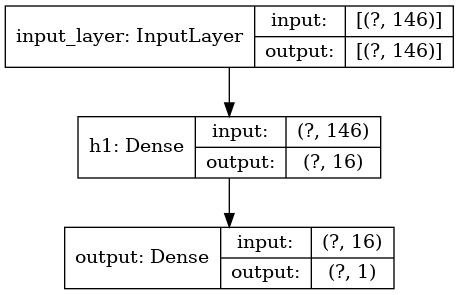

In [50]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,

)

## Compile

In [51]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer,loss=loss)

## Train the model

In [52]:
epochs = 50
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10,verbose=1, restore_best_weights=True)]
history = model.fit(x=X_train,y=train_df.rate.values, 
                  batch_size=32,
                  validation_data=(X_test,test_df.rate.values),
                  validation_batch_size=32,
                  epochs=epochs,
                  callbacks=callbacks
                 )

Epoch 1/50
912/912 [==============================] - 1s 1ms/step - loss: 0.3006 - val_loss: 0.1562
Epoch 2/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1467 - val_loss: 0.1346
Epoch 3/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1372 - val_loss: 0.1315
Epoch 4/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1319 - val_loss: 0.1272
Epoch 5/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1278 - val_loss: 0.1279
Epoch 6/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1235 - val_loss: 0.1278
Epoch 7/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1204 - val_loss: 0.1268
Epoch 8/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1190 - val_loss: 0.1192
Epoch 9/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1175 - val_loss: 0.1174
Epoch 10/50
912/912 [==============================] - 1s 1ms/step - loss: 0.1157 - val_loss: 0.1217

## Plot the model training history

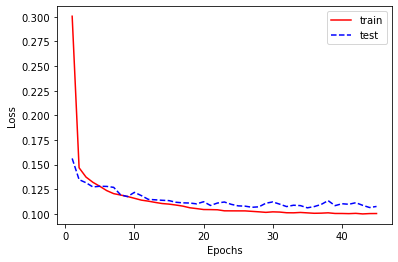

In [54]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epoch_list = np.arange(1,len(train_loss)+1,1)
plt.plot(epoch_list,train_loss,'-r',label='train')
plt.plot(epoch_list,val_loss,'--b', label='test')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Perform sample prediction and final model evaluation

In [55]:
from sklearn.metrics import r2_score
y_pred = model.predict(X_test).reshape(-1,)
y_pred = np.round(y_pred,decimals=1)
y_test = test_df.rate.values.reshape(-1,)
print('Pseudo R2: ', r2_score(y_true=y_test,y_pred=y_pred))

Pseudo R2:  0.447741221595937
